In [70]:
## Combine datasets
import glob
import torch
from pathlib import Path

def merge_pt_files(pt_paths):
    merged = {}
    for path in pt_paths:
        data = torch.load(path, map_location='cpu')
        if not merged:
            merged = {k: [v] for k, v in data.items()}
            continue
        if data.keys() != merged.keys():
            print(data.keys(),merged.keys())
            raise ValueError(f"Key mismatch in {path}")
        for k, v in data.items():
            merged[k].append(v)
    for k, tensors in merged.items():
        try:
            merged[k] = torch.cat(tensors, dim=0)
        except RuntimeError:
            merged[k] = tensors 
    return merged

pt_files = glob.glob("torchfem_dataset/panel_plasticity/*.pt")
combined = merge_pt_files(pt_files)
torch.save(combined, "torchfem_dataset/panel_plasticity/combined.pt")



In [ ]:
## Modify Dataset with Material Labels
import torch
import glob
from pathlib import Path
import pandas as pd
mat_df = pd.read_csv("../torchfem_dataset/tube/materials.csv")

files = glob.glob('../torchfem_dataset/panel_plasticity/simulation_dump*.pt')

material_map = {'concrete':0,'steel':1,'aluminum':2,'CFRP':3}

def stiffness_to_edges(K, num_nodes, dof_per_node=3):
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode='floor')
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode='floor')
    block_ids = node_rows * num_nodes + node_cols

    uniq_blocks, inverse = torch.unique(block_ids, return_inverse=True)
    local_row = dof_rows % dof_per_node
    local_col = dof_cols % dof_per_node
    flat_offsets = inverse * (dof_per_node * dof_per_node) + local_row * dof_per_node + local_col

    edge_attr_flat = torch.zeros(
        uniq_blocks.numel() * dof_per_node * dof_per_node,
        dtype=K.values().dtype,
        device=K.values().device,
    )
    edge_attr_flat.scatter_add_(0, flat_offsets, K.values())
    edge_attr = edge_attr_flat.view(uniq_blocks.numel(), dof_per_node, dof_per_node)

    senders = torch.div(uniq_blocks, num_nodes, rounding_mode='floor')
    receivers = uniq_blocks % num_nodes
    return senders.long(), receivers.long(), edge_attr.reshape(uniq_blocks.numel(), -1).float()

def build_graph_sample(material,sim, t_stride=1):
    nodes = sim["nodes"].float()
    u_hist = sim["u_history"][::t_stride].float()
    f_hist = sim["forces"][::t_stride].float()
    dirichlet = sim.get("dirichlet_disp", torch.zeros_like(nodes)).float()
    constraints = sim.get("boundary", sim.get("constraints", torch.zeros_like(nodes, dtype=torch.bool))).float()

    static = torch.cat([nodes, dirichlet, constraints], dim=-1)
    static = static.unsqueeze(0).expand(u_hist.size(0), -1, -1)
    dynamic = torch.cat([u_hist, f_hist], dim=-1)
    node_features = torch.cat([static, dynamic], dim=-1)

    senders, receivers, edge_features = stiffness_to_edges(
        sim["stiffness"],
        num_nodes=nodes.size(0),
        dof_per_node=nodes.size(1),
    )

    return {
        "node_features": node_features,
        "edge_features": edge_features,
        "senders": senders,
        "receivers": receivers,
        "target": u_hist,
    }

def preprocess_panel_dataset(src_dir="../torchfem_dataset/panel_plasticity",
                             dst_path="../torchfem_dataset/panel_processed.pt",
                             t_stride=1):
    src_dir = Path(src_dir)
    samples = []
    for pt_file in sorted(src_dir.glob("simulation_dump*.pt")):
        idx = int(str(pt_file).split('simulation_dump_')[1].split('.pt')[0])
        material = mat_df[mat_df['0']==idx]
        mat = material['1'].item()
        sim = torch.load(pt_file, map_location="cpu")
        samples.append(build_graph_sample(mat,sim, t_stride=t_stride))
    Path(dst_path).parent.mkdir(parents=True, exist_ok=True)
    #torch.save(samples, dst_path)
    print(f"Wrote {len(samples)} samples to {dst_path}")

# Run once to create the processed file
preprocess_panel_dataset()

aluminum
steel
aluminum
steel
aluminum
aluminum
steel
CFRP
CFRP
aluminum
aluminum
steel
steel
steel
aluminum
CFRP
CFRP
CFRP
steel
CFRP
CFRP
steel
CFRP
CFRP
CFRP
CFRP
aluminum
CFRP
aluminum
CFRP
steel
CFRP
aluminum
aluminum
CFRP
steel
aluminum
CFRP
CFRP
steel
steel
steel
CFRP
aluminum
CFRP
steel
aluminum
CFRP
CFRP
aluminum
steel
steel
aluminum
CFRP
steel
CFRP
aluminum
CFRP
steel
steel
aluminum
CFRP
aluminum
CFRP
aluminum
steel
steel
aluminum
aluminum
CFRP
CFRP
steel
CFRP
steel
steel
aluminum
CFRP
steel
CFRP
CFRP
steel
CFRP
aluminum
aluminum
aluminum
aluminum
steel
aluminum
CFRP
aluminum
CFRP
steel
steel
CFRP
steel
aluminum
CFRP
CFRP
steel
CFRP
aluminum
steel
CFRP
CFRP
aluminum
aluminum
steel
steel
aluminum
CFRP
CFRP
CFRP
steel
CFRP
steel
CFRP
aluminum
CFRP
CFRP
aluminum
CFRP
steel
CFRP
CFRP
Wrote 124 samples to ../torchfem_dataset/panel_processed.pt


In [13]:
## PyG HeteroData
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import numpy as np
import torch
from torch_geometric.data import HeteroData
import pandas as pd

def load_material_vocab(materials_csv: str) -> Tuple[Dict[str, int], Dict[int, str]]:
    df = pd.read_csv(materials_csv, header=None, names=["sim_id", "label"])
    labels = sorted(df["label"].astype(str).unique().tolist())
    vocab = {lbl: i for i, lbl in enumerate(labels)}
    sim_to_label = {int(r.sim_id): str(r.label) for _, r in df.iterrows()}
    return vocab, sim_to_label

def one_hot(label: str, vocab: Dict[str, int], device=None, dtype=torch.float) -> torch.Tensor:
    vec = torch.zeros(len(vocab), dtype=dtype, device=device)
    vec[vocab[label]] = 1.0
    return vec

def stiffness_to_node_adj_edge_index(K: torch.Tensor, num_nodes: int, dof_per_node: int = 3) -> torch.Tensor:
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode="floor")
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode="floor")
    ei = torch.stack([node_rows.long(), node_cols.long()], dim=0)
    mask = ei[0] != ei[1]
    ei = ei[:, mask]
    ei = torch.unique(ei, dim=1)
    return ei

def build_hetero_graph_for_sim(
    sim: Dict[str, torch.Tensor],
    material_label: str,
    material_vocab: Dict[str, int],
    edge_mode: str = "from_K"  # "from_K" or "knn" or "none"
    ) -> HeteroData:
    nodes = sim["nodes"].float()        # [N, 3]
    u_hist = sim["u_history"].float()   # [T, N, 3]
    f_hist = sim["forces"].float()      # [T, N, 3]
    dirichlet = sim.get("dirichlet_disp", torch.zeros_like(nodes)).float()  # [N, 3]
    constraints = sim.get("boundary", sim.get("constraints", torch.zeros_like(nodes, dtype=torch.bool))).float()

    data = HeteroData()

    # node-type features
    data["node"].pos = nodes                              # [N, d]
    data["node"].dirichlet = dirichlet                    # [N, dof]
    data["node"].bc_mask = constraints                    # [N, dof]
    data["node"].u_hist = u_hist                          # [T, N, dof]
    data["node"].f_hist = f_hist                          # [T, N, dof]

    # material-type node (one per sample)
    mat_oh = one_hot(material_label, material_vocab, device=nodes.device)
    data["mat"].x = mat_oh.unsqueeze(0)                   # [1, C]
    data["mat"].index = torch.tensor([material_vocab[material_label]], dtype=torch.long)

    # incidence from material to all nodes
    N = nodes.size(0)
    mat_to_nodes = torch.stack([torch.zeros(N, dtype=torch.long), torch.arange(N, dtype=torch.long)], dim=0)  # [2, N]
    data["mat", "applies_to", "node"].edge_index = mat_to_nodes
    data["node", "applies_to_rev", "mat"].edge_index = mat_to_nodes.flip(0)

    # optional node adjacency edges
    ei = stiffness_to_node_adj_edge_index(sim["stiffness"], num_nodes=N, dof_per_node=nodes.size(1))
    data["node", "adjacent", "node"].edge_index = ei
    data["node", "adjacent_rev", "node"].edge_index = ei.flip(0)

    # optional edge features (e.g., relative displacement or unit scalar)
    if ("node", "adjacent", "node") in data.edge_types:
        ei = data["node", "adjacent", "node"].edge_index
        data["node", "adjacent", "node"].edge_attr = (nodes[ei[1]] - nodes[ei[0]]).float()  # [E, d]

    # training targets
    data["node"].y = u_hist  # [T, N, dof]
    #data["node"].y = u_hist  # [T, N, dof] #TODO: add stress history

    return data

def build_hetero_dataset(
    src_dir: str = "../torchfem_dataset/panel_plasticity",
    materials_csv: str = "../torchfem_dataset/panel_plasticity/materials.csv",
    t_stride: int = 1,
    ) -> List[HeteroData]:
    vocab, sim_to_label = load_material_vocab(materials_csv)
    samples: List[HeteroData] = []
    for pt_file in sorted(Path(src_dir).glob("simulation_dump*.pt")):
        idx = int(str(pt_file).split("simulation_dump_")[1].split(".pt")[0])
        label = sim_to_label[idx]
        sim = torch.load(pt_file, map_location="cpu")
        sim["u_history"] = sim["u_history"][::t_stride]
        sim["forces"] = sim["forces"][::t_stride]
        data = build_hetero_graph_for_sim(sim, material_label=label, material_vocab=vocab)
        samples.append(data)
    return samples

dataset = build_hetero_dataset(
     src_dir="../torchfem_dataset/tube",
     materials_csv="../torchfem_dataset/tube/materials.csv",
     t_stride=1)
# torch.save(dataset, "../torchfem_dataset/panel_plasticity/hetero_panel.pt")

KeyboardInterrupt: 

In [ ]:
## PyG HeteroData
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import glob
import numpy as np
import torch
from torch_geometric.data import HeteroData
import pandas as pd

# ---------------------------
# Material encoding utilities
# ---------------------------

def load_material_vocab(materials_csv: str) -> Tuple[Dict[str, int], Dict[int, str]]:
    # CSV schema: sim_id,label
    df = pd.read_csv(materials_csv, header=None, names=["sim_id", "label"])
    #labels = sorted(df["label"].astype(str).unique().tolist())
    labels = ['concrete','steel','aluminum','CFRP']
    vocab = {lbl: i for i, lbl in enumerate(labels)}
    sim_to_label = {int(r.sim_id): str(r.label) for _, r in df.iterrows()}
    return vocab, sim_to_label

def one_hot(label: str, vocab: Dict[str, int], device=None, dtype=torch.float) -> torch.Tensor:
    vec = torch.zeros(len(vocab), dtype=dtype, device=device)
    vec[vocab[label]] = 1.0
    return vec

# ---------------------------
# Connectivity helpers
# ---------------------------

def get_cells_conn(
    sim: Dict[str, torch.Tensor],
    conn_path: Optional[str] = None,
    expected_arity: Optional[int] = None
) -> np.ndarray:
    """
    Returns (Nc, Nv) integer array of node indices per cell.
    Priority: sim['cells_conn'] -> conn_path ('.pt' or '.npy')
    """
    if "elements" in sim:
        conn = sim["elements"]
        conn = conn.cpu().numpy() if isinstance(conn, torch.Tensor) else np.asarray(conn)
        return conn.astype(np.int64, copy=False)

    if conn_path is not None:
        p = Path(conn_path)
        if p.suffix == ".pt":
            conn = torch.load(p, map_location="cpu")
            conn = conn.cpu().numpy() if isinstance(conn, torch.Tensor) else np.asarray(conn)
        elif p.suffix == ".npy":
            conn = np.load(p)
        else:
            raise ValueError(f"Unsupported conn_path suffix: {p.suffix}")
        conn = conn.astype(np.int64, copy=False)
        if expected_arity is not None and conn.shape[1] != expected_arity:
            raise ValueError(f"Connectivity arity mismatch: got {conn.shape[1]}, expected {expected_arity}")
        return conn

    raise KeyError("No cell connectivity found. Provide sim['cells_conn'] or conn_path.")

def incidence_edges_from_conn(conn: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Build cell->node incidence edges from connectivity.
    Returns (edge_index, edge_weight)
      - edge_index: LongTensor [2, E] with [cell_idx; node_idx]
      - edge_weight: FloatTensor [E, 1], default 1.0 (or 1/Nv if you prefer normalized)
    """
    Nc, Nv = conn.shape
    c_idx = np.repeat(np.arange(Nc, dtype=np.int64), Nv)
    n_idx = conn.reshape(-1)
    edge_index = torch.from_numpy(np.vstack([c_idx, n_idx])).long()
    edge_weight = torch.ones(edge_index.shape[1], 1, dtype=torch.float)
    return edge_index, edge_weight

def cell_adjacency_from_conn(conn: np.ndarray) -> torch.Tensor:
    """
    Create cell<->cell adjacency if cells share at least one node.
    Efficient build via inverted index node->cells.
    Returns LongTensor [2, E_cc]
    """
    Nc, Nv = conn.shape
    node_to_cells: Dict[int, List[int]] = {}
    for ci, nodes in enumerate(conn):
        for n in nodes.tolist():
            node_to_cells.setdefault(int(n), []).append(ci)

    edges = []
    for cells in node_to_cells.values():
        if len(cells) <= 1:
            continue
        # Complete graph among cells sharing this node
        for i in range(len(cells)):
            for j in range(i + 1, len(cells)):
                a, b = cells[i], cells[j]
                edges.append((a, b))
                edges.append((b, a))
    if not edges:
        return torch.empty(2, 0, dtype=torch.long)
    ei = torch.from_numpy(np.array(edges, dtype=np.int64).T).long()
    # Deduplicate
    ei = torch.unique(ei, dim=1)
    return ei

# ---------------------------
# Optional node adjacency (unchanged)
# ---------------------------

def stiffness_to_node_adj_edge_index(K: torch.Tensor, num_nodes: int, dof_per_node: int = 3) -> torch.Tensor:
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode="floor")
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode="floor")
    ei = torch.stack([node_rows.long(), node_cols.long()], dim=0)
    mask = ei[0] != ei[1]
    ei = ei[:, mask]
    ei = torch.unique(ei, dim=1)
    return ei

# ---------------------------
# Bipartite hetero graph builder
# ---------------------------

def build_bipartite_hetero_for_sim(
    sim: Dict[str, torch.Tensor],
    conn: np.ndarray,
    material_label: str,
    material_vocab: Dict[str, int],
    t_stride: int = 1,
    add_cell_adjacency: bool = True
) -> HeteroData:
    """
    node-type:
      pos, dirichlet, bc_mask, u_hist, f_hist
    cell-type:
      mat_type_index (int), mat_onehot (optional), centroid (optional)
    relations:
      (cell, contributes, node): incidence from conn
      optional (node, adjacent, node): from stiffness or knn
      optional (cell, adjacent, cell): share >=1 node
    """
    nodes = sim["nodes"].float()                              # [N, d]
    u_hist = sim["u_history"][::t_stride].float()             # [T, N, dof]
    f_hist = sim["forces"][::t_stride].float()                # [T, N, dof]
    dirichlet = sim.get("dirichlet_disp", torch.zeros_like(nodes)).float()  # [N, dof]
    constraints = sim.get("boundary", sim.get("constraints", torch.zeros_like(nodes, dtype=torch.bool))).float()

    data = HeteroData()

    # node features
    data["node"].pos = nodes
    data["node"].dirichlet = dirichlet
    data["node"].bc_mask = constraints
    data["node"].u_hist = u_hist
    data["node"].f_hist = f_hist

    # cell features
    Nc, Nv = int(conn.shape[0]), int(conn.shape[1])
    data["cell"].mat_type_index = torch.full((Nc,), fill_value=material_vocab[material_label], dtype=torch.long)
    data["cell"].mat_onehot = one_hot(material_label, material_vocab, device=nodes.device).unsqueeze(0).repeat(Nc, 1)

    # optional: cell centroid
    with torch.no_grad():
        conn_t = torch.from_numpy(conn).long()
        centroids = nodes[conn_t].mean(dim=1)  # [Nc, d]
    data["cell"].centroid = centroids

    # incidence edges cell->node
    c2n_ei, c2n_w = incidence_edges_from_conn(conn)  # [2, E_cn], [E_cn, 1]
    data["cell", "contributes", "node"].edge_index = c2n_ei
    data["cell", "contributes", "node"].edge_weight = c2n_w
    data["node", "belongs_to", "cell"].edge_index = c2n_ei.flip(0)
    data["node", "belongs_to", "cell"].edge_weight = c2n_w

    # optional node adjacency
    ei = stiffness_to_node_adj_edge_index(sim["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1))
    data["node", "adjacent", "node"].edge_index = ei
    data["node", "adjacent_rev", "node"].edge_index = ei.flip(0)
    data["node", "adjacent", "node"].edge_attr = (nodes[ei[1]] - nodes[ei[0]]).float()

    # optional cell adjacency
    if add_cell_adjacency:
        cc_ei = cell_adjacency_from_conn(conn)
        data["cell", "adjacent", "cell"].edge_index = cc_ei
        data["cell", "adjacent_rev", "cell"].edge_index = cc_ei.flip(0)
        if cc_ei.numel() > 0:
            cent = data["cell"].centroid
            data["cell", "adjacent", "cell"].edge_attr = (cent[cc_ei[1]] - cent[cc_ei[0]]).float()

    # training target
    data["node"].y = u_hist  # [T, N, dof]
    return data

# ---------------------------
# End-to-end dataset builder
# ---------------------------

def build_bipartite_hetero_dataset(
    src_dir: str = "../torchfem_dataset/panel_plasticity",
    materials_csv: str = "../torchfem_dataset/panel_plasticity/materials.csv",
    expected_cell_arity: Optional[int] = None,  # e.g., 8 for hex
    t_stride: int = 1,
    add_cell_adjacency: bool = True
) -> List[HeteroData]:
    vocab, sim_to_label = load_material_vocab(materials_csv)
    samples: List[HeteroData] = []
    for pt_file in sorted(Path(src_dir).glob("simulation_dump*.pt")):
        idx = int(str(pt_file).split("simulation_dump_")[1].split(".pt")[0])
        label = sim_to_label[idx]
        label = 'concrete'
        sim = torch.load(pt_file, map_location="cpu")
        conn = get_cells_conn(sim, conn_path=None, expected_arity=expected_cell_arity)
        data = build_bipartite_hetero_for_sim(
            sim=sim,
            conn=conn,
            material_label=label,
            material_vocab=vocab,
            t_stride=t_stride,
            add_cell_adjacency=add_cell_adjacency,
        )
        print(pt_file)
        samples.append(data)
    return samples

# ---------------------------
# Example usage
# ---------------------------

dataset = build_bipartite_hetero_dataset(
     src_dir="../torchfem_dataset/unreinforced_concrete",
     materials_csv="../torchfem_dataset/tube/materials.csv",
     expected_cell_arity=8,
     t_stride=1,
     add_cell_adjacency=True)

torch.save(dataset, "../torchfem_dataset/hetero_slab.pt")

..\torchfem_dataset\unreinforced_concrete\simulation_dump_1.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_10.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_100.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_101.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_102.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_103.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_104.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_105.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_106.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_107.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_108.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_109.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_11.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_110.pt
..\torchfem_dataset\unreinforced_concrete\simulation_dump_111.pt
..\torchfem_dataset\unreinfor

In [21]:
simdata = torch.load('../torchfem_dataset/hetero_tube.pt',weights_only=False)[0]
print(simdata['node'])


{'pos': tensor([[ 0.0000,  0.0000, 19.4318],
        [ 0.0000,  0.0000, 20.4545],
        [ 0.0000,  0.0000, 21.4773],
        ...,
        [45.0000, 40.0000, 23.5227],
        [45.0000, 40.0000, 24.5455],
        [45.0000, 40.0000, 25.5682]]), 'dirichlet': tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), 'bc_mask': tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), 'u_hist': tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0018, -0.0003,  0.0005],
         [ 0.0017

In [8]:
from typing import Dict, Any, List, Optional
import numpy as np
import torch
from torch_geometric.data import HeteroData
import pandas as pd

def build_and_save_hetero_hex_graph(
    fe: Dict[str, Any],
    out_path: str = "mesh_graph.pt",
    k_history: int = 3,
    include_stress_invariants: bool = True,
    material_vocab: Optional[Dict[str, int]] = None,
) -> str:
    """
    Build a bipartite (nodes<->cells) HeteroData graph for hex meshes and save to .pt

    Expected 'fe' dictionary structure (numpy arrays unless noted):
    fe = {
        'nodes': {
            'pos':       (N, 3)          node coordinates
            'f':         (N, dof)        nodal forces (e.g., dof=3)
            'bc_mask':   (N, dof)        1 if Dirichlet fixed on that dof, else 0
            'bc_value':  (N, dof)        Dirichlet value per dof (0 if mask=0)
            'u_hist':    (T, N, dof)     displacement history over T steps (last index is current)
        },
        'cells': {
            'conn':      (Nc, 8)         hex connectivity using node indices [0..N-1]
            'mat_scalars': dict of per-cell arrays of length Nc, e.g.:
                { 'E': (Nc,), 'nu': (Nc,), 'sigma_y': (Nc,), 'G_f': (Nc,), ... }
            'mat_type':  List[str] or (Nc,) array of material/phase labels (e.g. 'concrete', 'steel')
            'D_hist':    (T, Nc)         damage history (optional; else None)
            'ep_hist':   (T, Nc)         plastic strain invariant history (optional)
            'stress_inv_hist': (T, Nc, 3) invariants [I1, sqrt(J2), Lode] (optional)
        }
    }

    Parameters
    ----------
    out_path : where to torch.save() the HeteroData
    k_history : number of last increments to aggregate (simple deltas/EMAs)
    include_stress_invariants : if True and available, add current stress invariants to cell.x
    material_vocab : optional mapping {material_name: index}. If None, built from fe['cells']['mat_type'].

    Returns
    -------
    out_path : path to the saved .pt
    """

    # ------- Helpers -------
    def to_t(x):
        return torch.from_numpy(x).float()

    def ensure_np(a, ndim=None):
        if a is None:
            return None
        a = np.asarray(a)
        if ndim is not None and a.ndim != ndim:
            raise ValueError(f"Expected ndim={ndim}, got {a.ndim}")
        return a

    def last_and_delta_sum(seq, k):
        """
        seq: (T, ..., C) returns (last, sum of last k deltas)
        deltas computed as seq[t] - seq[t-1], starting from t=T-k..T-1
        """
        if seq is None:
            return None, None
        T = seq.shape[0]
        last = seq[-1]
        if T < 2:
            delta_sum = np.zeros_like(last)
        else:
            start = max(1, T - k)
            deltas = seq[start:T] - seq[start-1:T-1]
            delta_sum = deltas.sum(axis=0)
        return last, delta_sum

    def hex_centroids(pos, conn):
        # centroid = mean of corner node positions
        return pos[conn].mean(axis=1)  # (Nc, 3)

    def build_material_vocab(mt):
        if isinstance(mt, (list, tuple)):
            labels = list(mt)
        else:
            labels = list(np.asarray(mt).tolist())
        uniq = sorted(set(labels))
        return {name: i for i, name in enumerate(uniq)}

    # ------- Ingest inputs -------
    nodes = fe['nodes']
    cells = fe['cells']

    pos = ensure_np(nodes['pos'], ndim=2)            # (N,3)
    f = ensure_np(nodes.get('f'), ndim=2)            # (N,dof)
    bc_mask = ensure_np(nodes.get('bc_mask'), ndim=2)  # (N,dof)
    u_hist = ensure_np(nodes.get('u_hist'), ndim=3)  # (T,N,dof)

    conn = ensure_np(cells['conn'], ndim=2)          # (Nc,8)
    mat_scalars: Dict[str, np.ndarray] = cells.get('mat_scalars', {}) or {}
    mat_type = cells.get('mat_type')
    D_hist = ensure_np(cells.get('D_hist'), None)    # (T,Nc) or None
    ep_hist = ensure_np(cells.get('ep_hist'), None)  # (T,Nc) or None
    stress_inv_hist = ensure_np(cells.get('stress_inv_hist'), None)  # (T,Nc,3) or None

    N = pos.shape[0]
    Nc = conn.shape[0]
    dof = f.shape[1] if f is not None else (u_hist.shape[2] if u_hist is not None else 3)

    # Sanity checks
    if conn.shape[1] != 8:
        raise ValueError("This helper assumes 8-node hexes (conn shape (Nc, 8)).")

    # ------- Temporal features -------
    u_last, u_dsum = last_and_delta_sum(u_hist, k_history)  # (N,dof), (N,dof) or None
    if u_last is None:
        u_last = np.zeros((N, dof), dtype=np.float32)
    if u_dsum is None:
        u_dsum = np.zeros((N, dof), dtype=np.float32)

    D_last, D_dsum = last_and_delta_sum(D_hist, k_history) if D_hist is not None else (None, None)
    ep_last, ep_dsum = last_and_delta_sum(ep_hist, k_history) if ep_hist is not None else (None, None)
    sig_last = stress_inv_hist[-1] if (include_stress_invariants and stress_inv_hist is not None) else None  # (Nc,3)

    # ------- Cell geometry -------
    c_centroids = hex_centroids(pos, conn)  # (Nc,3)
    # cheap proxies (you can replace with actual FE-computed values if available)
    # volume proxy via bounding box volume of the 8 nodes (rough)
    bb_min = pos[conn].min(axis=1)
    bb_max = pos[conn].max(axis=1)
    vol_proxy = np.prod(np.clip(bb_max - bb_min, 1e-9, None), axis=1)  # (Nc,)
    # quality proxy: inverse of max aspect ratio (crude)
    edges = pos[conn][:, :, None, :] - pos[conn][:, None, :, :]  # (Nc,8,8,3)
    edge_len = np.linalg.norm(edges.reshape(Nc, -1, 3), axis=-1)  # (Nc,64)
    max_l = edge_len.max(axis=1) + 1e-9
    min_l = edge_len[edge_len > 0].reshape(Nc, -1).min(axis=1) + 1e-9
    quality = (min_l / max_l)  # (Nc,)

    # ------- Node↔Cell incidence edges -------
    # node->cell: for each cell c and local corner k, add edge (n=c[k] -> c)
    n_idx = conn.reshape(-1)                                # (Nc*8,)
    c_idx = np.repeat(np.arange(Nc), 8)                     # (Nc*8,)
    n2c_edge_index = np.vstack([n_idx, c_idx])              # [2, E_nc]

    # Edge attributes: vector node->centroid, distance, unit vector
    vec = c_centroids[c_idx] - pos[n_idx]                   # (E,3)
    dist = np.linalg.norm(vec, axis=1, keepdims=True)       # (E,1)
    unit = np.divide(vec, np.clip(dist, 1e-12, None))       # (E,3)
    n2c_edge_attr = np.concatenate([vec, dist, unit], axis=1)  # (E, 7)

    # cell->node is just the transpose index-wise
    c2n_edge_index = n2c_edge_index[::-1, :].copy()
    c2n_edge_attr = n2c_edge_attr.copy()  # symmetric choice is fine

    # ------- Material categorical embedding index -------
    if material_vocab is None:
        material_vocab = build_material_vocab(mat_type)
    if isinstance(mat_type, (list, tuple)):
        mat_idx = np.array([material_vocab[m] for m in mat_type], dtype=np.int64)
    else:
        # if already numeric labels but unknown mapping, map to a compact 0..K-1 space
        uniq = {int(v): i for i, v in enumerate(sorted(set(np.asarray(mat_type).astype(int).tolist())))}
        mat_idx = np.array([uniq[int(v)] for v in np.asarray(mat_type).astype(int)], dtype=np.int64)

    # ------- Assemble node.x -------
    node_feats = [u_last, u_dsum]
    if f is not None:         node_feats.append(f)
    if bc_mask is not None:   node_feats.append(bc_mask)
    node_x = np.concatenate(node_feats, axis=1).astype(np.float32)  # (N, d_node)

    # ------- Assemble cell.x -------
    # material scalars (sorted for determinism)
    mat_keys = sorted(mat_scalars.keys())
    mat_scalar_stack = np.stack([mat_scalars[k].astype(np.float32) for k in mat_keys], axis=1) if mat_keys else np.zeros((Nc, 0), dtype=np.float32)

    cell_feats = [mat_scalar_stack,
                  vol_proxy[:, None].astype(np.float32),
                  quality[:, None].astype(np.float32)]

    # add optional histories
    if D_last is not None:   cell_feats += [D_last[:, None].astype(np.float32)]
    if D_dsum is not None:   cell_feats += [D_dsum[:, None].astype(np.float32)]
    if ep_last is not None:  cell_feats += [ep_last[:, None].astype(np.float32)]
    if ep_dsum is not None:  cell_feats += [ep_dsum[:, None].astype(np.float32)]
    if sig_last is not None: cell_feats += [sig_last.astype(np.float32)]

    cell_x = np.concatenate(cell_feats, axis=1) if len(cell_feats) > 0 else np.zeros((Nc, 1), dtype=np.float32)
    cell_x = cell_x.astype(np.float32)

    # ------- Build HeteroData -------
    data = HeteroData()

    data['node'].x = to_t(node_x)                           # (N, d_node)
    data['node'].pos = to_t(pos)                            # keep coordinates if you want later

    data['cell'].x = to_t(cell_x)                           # (Nc, d_cell)
    data['cell'].centroid = to_t(c_centroids)               # (Nc, 3)
    data['cell'].mat_type_index = torch.from_numpy(mat_idx).long()  # categorical index for embedding table

    data['node', 'incides', 'cell'].edge_index = torch.from_numpy(n2c_edge_index).long()
    data['node', 'incides', 'cell'].edge_attr  = to_t(n2c_edge_attr)

    data['cell', 'contributes', 'node'].edge_index = torch.from_numpy(c2n_edge_index).long()
    data['cell', 'contributes', 'node'].edge_attr  = to_t(c2n_edge_attr)

    # Optionally, you may add per-target tensors here (e.g., ground-truth u and stress for supervision)
    # Example:
    if u_last is not None:
        data['node'].y_u = to_t(u_last)                     # ground-truth displacement at current step
    if include_stress_invariants and sig_last is not None:
        data['cell'].y_stress_inv = to_t(sig_last)          # [I1, sqrt(J2), Lode] at current step
    if D_last is not None:
        data['cell'].y_damage = to_t(D_last[:, None])

    # Save
    #torch.save(data, out_path)
    return out_path


# -----------------
# Example usage
# -----------------
simdata = torch.load('../torchfem_dataset/tube/simulation_dump_2.pt')
mat_df = pd.read_csv("../torchfem_dataset/tube/materials.csv")
src_dir="../torchfem_dataset/tube"
src_dir = Path(src_dir)

# Minimal synthetic example (replace with your real arrays)
for pt_file in sorted(src_dir.glob("simulation_dump*.pt")):
    N, Nc, T, dof = 10, 3, 5, 3

    idx = int(str(pt_file).split('simulation_dump_')[1].split('.pt')[0])
    material = mat_df[mat_df['0']==idx]
    mat = material['1'].item()
    if mat == 'steel':
        E = np.full(3,210e9)
        nu = np.full(3,0.3)
    if mat == 'aluminum':
        E = np.full(3,70e9)
        nu = np.full(3,0.3)
    if mat == 'CFRP':
        continue



    fe = {'nodes': {
        'pos': simdata['nodes'],
        'f': simdata['forces'],
        'bc_mask': simdata['boundary'],
        'u_hist': simdata['u_history']
    },
    'cells': {
        'conn':simdata['elements'],
        'mat_scalars': {
            'E':E,
            'nu':nu
        },
        'mat_type':[mat],
        'D_hist': simdata['state']
    }
    }

    vocab = {'concrete': 0, 'steel': 1, 'aluminum':2, 'CFRP':3}
    path = build_and_save_hetero_hex_graph(fe, out_path="mesh_graph.pt", k_history=3, material_vocab=vocab)
    print(f"Saved: {path}")


ValueError: Expected ndim=2, got 3

In [28]:
## Preprocess dataset
import torch
from pathlib import Path

def stiffness_to_edges(K, num_nodes, dof_per_node=3):
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode='floor')
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode='floor')
    block_ids = node_rows * num_nodes + node_cols

    uniq_blocks, inverse = torch.unique(block_ids, return_inverse=True)
    local_row = dof_rows % dof_per_node
    local_col = dof_cols % dof_per_node
    flat_offsets = inverse * (dof_per_node * dof_per_node) + local_row * dof_per_node + local_col

    edge_attr_flat = torch.zeros(
        uniq_blocks.numel() * dof_per_node * dof_per_node,
        dtype=K.values().dtype,
        device=K.values().device,
    )
    edge_attr_flat.scatter_add_(0, flat_offsets, K.values())
    edge_attr = edge_attr_flat.view(uniq_blocks.numel(), dof_per_node, dof_per_node)

    senders = torch.div(uniq_blocks, num_nodes, rounding_mode='floor')
    receivers = uniq_blocks % num_nodes
    return senders.long(), receivers.long(), edge_attr.reshape(uniq_blocks.numel(), -1).float()

def build_graph_sample(sim, t_stride=1):
    nodes = sim["nodes"].float()
    u_hist = sim["u_history"][::t_stride].float()
    f_hist = sim["forces"][::t_stride].float()
    dirichlet = sim.get("dirichlet_disp", torch.zeros_like(nodes)).float()
    constraints = sim.get("boundary", sim.get("constraints", torch.zeros_like(nodes, dtype=torch.bool))).float()

    static = torch.cat([nodes, dirichlet, constraints], dim=-1)
    static = static.unsqueeze(0).expand(u_hist.size(0), -1, -1)
    dynamic = torch.cat([u_hist, f_hist], dim=-1)
    node_features = torch.cat([static, dynamic], dim=-1)

    senders, receivers, edge_features = stiffness_to_edges(
        sim["stiffness"],
        num_nodes=nodes.size(0),
        dof_per_node=nodes.size(1),
    )

    return {
        "node_features": node_features,
        "edge_features": edge_features,
        "senders": senders,
        "receivers": receivers,
        "target": u_hist,  # optional, but handy if you switch the training loop to use it
    }

def preprocess_panel_dataset(src_dir="torchfem_dataset/panel_plasticity",
                             dst_path="torchfem_dataset/panel_plasticity/panel_processed.pt",
                             t_stride=1):
    src_dir = Path(src_dir)
    samples = []
    for pt_file in sorted(src_dir.glob("simulation_dump*.pt")):
        sim = torch.load(pt_file, map_location="cpu")
        samples.append(build_graph_sample(sim, t_stride=t_stride))
    Path(dst_path).parent.mkdir(parents=True, exist_ok=True)
    torch.save(samples, dst_path)
    print(f"Wrote {len(samples)} samples to {dst_path}")

# Run once to create the processed file
preprocess_panel_dataset()

Wrote 20 samples to torchfem_dataset/panel_plasticity/panel_processed.pt


In [ ]:
## PyTorch Geometric Data

import torch
from torch_geometric.data import HeteroData

def load_simulation_graph(path: str, t_stride: int = 1) -> HeteroData:
    sim = torch.load(path)
    print(sim)
    nodes_xyz = sim["nodes"]                                     # (N, 3)
    u_hist = sim["u_history"][::t_stride]                        # (T, N, 3)
    f_hist = sim["forces"][::t_stride]                           # (T, N, 3)
    constraints = sim.get("constraints", torch.zeros_like(nodes_xyz, dtype=torch.bool))
    dirichlet = sim.get("dirichlet_disp", torch.zeros_like(nodes_xyz))

    # Node features: coords + flattened time histories + BC masks
    node_feat = torch.cat([
        nodes_xyz,
        u_hist.reshape(u_hist.size(0), -1, 3).transpose(0, 1).reshape(nodes_xyz.size(0), -1),
        f_hist.reshape(f_hist.size(0), -1, 3).transpose(0, 1).reshape(nodes_xyz.size(0), -1),
        dirichlet,
        constraints.float(),                                     # keep mask as float
    ], dim=1)

    # Cell (element) features
    elements = sim["elements"].long()                            # (E, n_nodes_per_elem)
    F_hist = sim["deform_grad"][::t_stride].reshape(len(u_hist), elements.size(0), -1)
    stress_hist = sim["stress_history"][::t_stride].reshape(len(u_hist), elements.size(0), -1)
    damage = sim.get("state", torch.zeros_like(stress_hist[..., :1]))[::t_stride].reshape(len(u_hist), elements.size(0), -1)
    cell_feat = torch.cat([
        F_hist.transpose(0, 1).reshape(elements.size(0), -1),
        stress_hist.transpose(0, 1).reshape(elements.size(0), -1),
        damage.transpose(0, 1).reshape(elements.size(0), -1),
    ], dim=1)

    # Stiffness → node↔node edges
    K = sim["stiffness"].coalesce()
    n_dim = nodes_xyz.size(1)                                    # 3 DOFs per node
    dof_rows, dof_cols = K.indices()
    node_rows = (dof_rows // n_dim)
    node_cols = (dof_cols // n_dim)
    block_ids = node_rows * nodes_xyz.size(0) + node_cols
    uniq_blocks, inverse = torch.unique(block_ids, return_inverse=True)

    local_row = dof_rows % n_dim
    local_col = dof_cols % n_dim
    flat_offsets = inverse * (n_dim * n_dim) + local_row * n_dim + local_col
    edge_attr_flat = torch.zeros(
        uniq_blocks.numel() * n_dim * n_dim,
        dtype=K.values().dtype,
        device=K.values().device,
    )
    edge_attr_flat.scatter_add_(0, flat_offsets, K.values())
    edge_attr = edge_attr_flat.view(uniq_blocks.numel(), n_dim, n_dim)
    senders = (uniq_blocks / node_feat.size(0)).floor().long()
    receivers = uniq_blocks % node_feat.size(0)
    edge_index = torch.stack([senders, receivers], dim=0)

    # Incidence edges from cells to their nodes
    e_idx = torch.arange(elements.size(0)).repeat_interleave(elements.size(1))
    node_idx = elements.reshape(-1)
    incidence = torch.stack([e_idx, node_idx], dim=0)

    data = HeteroData()
    data["node"].x = node_feat
    data["cell"].x = cell_feat
    data["node", "stiffness", "node"].edge_index = edge_index
    data["node", "stiffness", "node"].edge_attr = edge_attr.reshape(edge_attr.size(0), -1)
    data["cell", "incidence", "node"].edge_index = incidence
    data["node", "incidence_rev", "cell"].edge_index = incidence.flip(0)  # optional reverse relation
    data["globals"].x = torch.tensor([[u_hist.size(0)]], dtype=torch.float32)  # example global feature
    return data

load_simulation_graph("torchfem_dataset/panel_plasticity/panel_processed.pt")

[{'node_features': tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  5.8125e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.1625e+01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 6.0000e+01,  8.7500e+01,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 6.0000e+01,  8.7500e+01,  5.8125e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 6.0000e+01,  8.7500e+01,  1.1625e+01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.8682e-02,
           1.5992e-02,  5.1335e-01],
         [ 0.0000e+00,  0.0000e+00,  5.8125e+00,  ..., -2.3245e-16,
           4.3889e-16, -1.6653e-16],
         [ 0.0000e+00,  0.0000e+00,  1.1625e+01,  ...,  7.7542e-16,
           8.0968e-16, -1.7651e-16],
         ...,
      

TypeError: list indices must be integers or slices, not str

In [25]:
## GraphNet Architecture

import torch
import torch.nn as nn

class GraphNetBlock(nn.Module):
    def __init__(self, node_dim, edge_dim, global_dim=0, hidden_dim=64):
        super().__init__()
        self.global_dim = global_dim

        # Edge update φ^e
        in_dim_e = edge_dim + 2*node_dim + global_dim
        self.edge_mlp = nn.Sequential(
            nn.Linear(in_dim_e, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, edge_dim)
        )

        # Node update φ^v
        in_dim_v = node_dim + edge_dim + global_dim
        self.node_mlp = nn.Sequential(
            nn.Linear(in_dim_v, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_dim)
        )

        self.global_mlp = None

    def forward(self, nodes, edges, senders, receivers, global_attr=None):
        N, E = nodes.size(0), edges.size(0)

        g_e = torch.zeros(E, 0, device=nodes.device)
        g_v = torch.zeros(N, 0, device=nodes.device)

        # ---- Edge update ----
        #print(edges.shape, nodes[senders].shape, nodes[receivers].shape, g_e.shape)
        edge_inputs = torch.cat([edges, nodes[senders], nodes[receivers], g_e], dim=-1)
        edges_updated = self.edge_mlp(edge_inputs)

        # ---- Node update ----
        agg_messages = torch.zeros(N, edges_updated.size(-1), device=nodes.device)
        agg_messages.index_add_(0, receivers, edges_updated)  # ρ^{e→v} = sum
        node_inputs = torch.cat([nodes, agg_messages, g_v], dim=-1)
        nodes_updated = self.node_mlp(node_inputs)

        return nodes_updated, edges_updated


In [2]:
## LSTM-Type Architecture with rollout

import torch
import torch.nn as nn

def reset_weights(m):
    if hasattr(m, "reset_parameters"):
        m.reset_parameters()

class GraphTemporalModel(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, out_dim):
        super().__init__()
        self.gn = GraphNetBlock(node_dim, edge_dim)
        self.rnn = nn.LSTM(input_size=node_dim, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, out_dim)
        self.reset_parameters()

    def reset_parameters(self):
        self.gn.apply(reset_weights)
        for name, param in self.rnn.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            else:
                nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.zeros_(self.decoder.bias)


    def forward(self, x_t, edge_features, senders, receivers, h=None, c=None):
        """
        One-step prediction:
          x_t : [B, N, F]  current node features
          edge_features : [E, d_e]
          senders, receivers : [E]
          h, c : LSTM hidden + cell state
        Returns:
          x_next : [B, N, out_dim]
          (h, c) : updated hidden states
        """
        # Graph update
        gn_out, _ = self.gn(x_t, edge_features, senders, receivers)  # [B, N, F]

        # Reshape node features for RNN (flatten nodes as features)
        rnn_in = gn_out.reshape(gn_out.size(0), 1, -1)  # [B, 1, N*F]

        # RNN step
        if h is not None and c is not None:
            rnn_out, (h, c) = self.rnn(rnn_in, (h, c))
        else:
            rnn_out, (h, c) = self.rnn(rnn_in)

        # Decode next node features
        x_next = self.decoder(rnn_out)  # [B, 1, out_dim]
        x_next = x_next.squeeze(1)      # [B, out_dim]

        return x_next, (h, c)

    def rollout(self, node_init, edge_features, senders, receivers, steps): ##TODO: time-dependent
        """
        Autoregressive rollout for multiple steps.
          node_init : [B, N, F]  initial node features
          steps     : number of rollout steps
        Returns:
          preds : [B, steps, out_dim]
        """
        preds = []
        x_t = node_init
        h, c = None, None

        for _ in range(steps):
            x_t, (h, c) = self.forward(x_t, edge_features, senders, receivers, h, c)
            preds.append(x_t)

        return torch.stack(preds, dim=1)  # [B, steps, out_dim]



In [26]:
## LSTM-Type Architecture without rollout

def reset_weights(m):
    if hasattr(m, "reset_parameters"):
        m.reset_parameters()

class GraphTemporalModelNoRollout(nn.Module):
    def __init__(self, static_dim, state_dim, cond_dim, edge_dim, hidden_dim):
        super().__init__()
        self.static_dim = static_dim
        self.state_dim = state_dim
        self.cond_dim = cond_dim
        self.node_dim = static_dim + state_dim + cond_dim

        self.gn = GraphNetBlock(self.node_dim, edge_dim)
        self.rnn = nn.LSTM(input_size=self.node_dim, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, self.state_dim)
        self.reset_parameters()

    def reset_parameters(self):
        self.gn.apply(reset_weights)
        for name, param in self.rnn.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            else:
                nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.zeros_(self.decoder.bias)

    def forward(self, state_t, cond_t, static_feat, edge_features, senders, receivers, hc=None):
        # combine current prediction with known context
        nodes = torch.cat([static_feat, state_t, cond_t], dim=-1)
        
        nodes, _ = self.gn(nodes, edge_features, senders, receivers)

        #rnn_in = nodes.reshape(1, 1, -1) if nodes.dim() == 2 else nodes.reshape(nodes.size(0), 1, -1)
        #print(self.state_dim,self.node_dim,nodes.shape)
        #print(nodes.shape,edge_features.shape,senders.shape,receivers.shape)
        rnn_out, hc = self.rnn(nodes, hc) if hc else self.rnn(nodes)
        #rnn_out, hc = self.rnn(rnn_in, hc) if hc else self.rnn(rnn_in)
        next_state = self.decoder(rnn_out.squeeze(1)).view_as(state_t)
        return next_state, hc

    def rollout(self, state_init, cond_seq, static_feat, edge_features, senders, receivers):
        preds = []
        state = state_init
        hc = None
        for cond_t in cond_seq:
            state, hc = self.forward(state, cond_t, static_feat, edge_features, senders, receivers, hc)
            preds.append(state)
        return torch.stack(preds, dim=0)


In [2]:
import torch
simdata = torch.load('../torchfem_dataset/panel_plasticity/simulation_dump_2.pt')

In [4]:
## Get Dataset

from torch.utils.data import Dataset, DataLoader
import torch

class GraphSeqDataset(Dataset):
    def __init__(self, pt_path):
        raw = torch.load(pt_path, map_location="cpu")
        # assume file is either a list[dict] or a dict of tensors
        if isinstance(raw, dict) and all(torch.is_tensor(v) for v in raw.values()):
            self.samples = [
                {k: v[i] for k, v in raw.items()}
                for i in range(next(iter(raw.values())).size(0))
            ]
        else:
            self.samples = raw

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return {
            "node_features": sample["node_features"].float(),
            "edge_features": sample["edge_features"].float(),
            "senders": sample["senders"].long(),
            "receivers": sample["receivers"].long(),
            "target": sample.get("target", sample["node_features"]).float(),
        }

def graph_collate(batch):
    # handles batch size >1; adjust if sequences have different lengths
    out = {}
    for key in batch[0]:
        vals = [item[key] for item in batch]
        if key in {"senders", "receivers"}:
            out[key] = torch.stack(vals, dim=0)
        else:
            out[key] = torch.stack(vals, dim=0)
    return out

dataset = GraphSeqDataset("torchfem_dataset/panel_plasticity/panel_processed.pt")
loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=graph_collate)


In [ ]:
# GraphNet training loop - LSTM
from torch.utils.data import DataLoader
from torch import optim
import time

#dataset = torch.load('torchfem_dataset/panel_plasticity/simulation_.pt')
#loader = DataLoader(dataset, batch_size=1, shuffle=True)  # batch size 1 for rollout
device = 'cuda:0'
loader = DataLoader(dataset, batch_size=1, collate_fn=graph_collate)

sample = next(iter(dataset))
node_dim = sample["node_features"].shape[-1]
edge_dim = sample["edge_features"].shape[-1]
out_dim = node_dim                # or whatever target width you predict

gn = GraphTemporalModel(
    node_dim=node_dim,
    edge_dim=edge_dim,
    hidden_dim=128,
    out_dim=out_dim,
).to(device)
gn.apply(reset_weights)

optimizer = optim.AdamW(gn.parameters(), lr=5e-2)
loss_fn = nn.SmoothL1Loss() ##TODO: physics-informed loss
epochs = 10
losses = []

def rollout_from_dataset(gn, node_features_seq, edge_features, 
                         senders, receivers):
    """
    Unroll the GN across the sequence length T.
    """
    T, N, F = node_features_seq.shape[0], node_features_seq.shape[1], node_features_seq.shape[1:]
    preds = []

    nodes_t = node_features_seq[0]  # initial state
    for t in range(T-1):
        # forward pass
        #print(nodes_t.shape,edge_features.shape,senders.shape,receivers.shape)
        nodes_t, _= gn(nodes_t, edge_features, senders, receivers) #nodes_t,_,_
        preds.append(nodes_t)   # keep entire state prediction
    return torch.stack(preds, dim=0)  # [T-1, N, F]

max_batches = 5
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(loader):
        if batch_idx >= max_batches:
            break
        node_features_seq, edge_features, senders, receivers, target_seq = batch['node_features'],batch['edge_features'],batch['senders'],batch['receivers'],batch['node_features']
        
        node_features_seq = node_features_seq.squeeze(0)      # [T,N,F]
        steps = node_features_seq.shape[0]
        edge_features = edge_features.squeeze(0)              # [E,D]
        #global_features_seq = global_features_seq.squeeze(0)  # [T,G]
        target_seq = target_seq.squeeze(0)                    # [T,N,out_dim]
        senders = senders.squeeze(0)
        receivers = receivers.squeeze(0)
        #preds = rollout_from_dataset(gn, node_features_seq, edge_features,
        #    senders, receivers)

        preds = gn.rollout(node_features_seq[0], edge_features, senders, receivers, steps)
        preds = preds.permute(1,0,2)
        # preds covers [1..T-1], align with ground truth
        #print(preds.shape,target_seq.shape)
        loss = loss_fn(preds[1:], target_seq[1:])  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        #print(total_loss)
    losses.append(total_loss)

    #if epoch % 20 == 0:
    print(f"Epoch {epoch}, Loss={total_loss/len(loader):.2f}")
torch.save({'model':gn.state_dict(),'optimizer':optimizer.state_dict()},'torchfem_dataset/weights.pth')


torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([32670, 15]) torch.Size([32670, 0])
torch.Size([32670, 9]) torch.Size([32670, 15]) torch.Size([3

KeyboardInterrupt: 

In [4]:
# GraphNet training loop - LSTM no rollout
from torch.utils.data import DataLoader
from torch import optim
import time

#dataset = torch.load('torchfem_dataset/panel_plasticity/simulation_.pt')
#loader = DataLoader(dataset, batch_size=1, shuffle=True)  # batch size 1 for rollout
device = 'cpu'
dataset = GraphSeqDataset("torchfem_dataset/panel_plasticity/panel_processed.pt")
loader = DataLoader(dataset, batch_size=1, collate_fn=graph_collate)

sample = next(iter(dataset))
node_features_seq, edge_features, senders, receivers, target_seq = sample['node_features'],sample['edge_features'],sample['senders'],sample['receivers'],sample['target']


node_features_seq = node_features_seq.squeeze(0)        # [T, N, F]
time_diff = node_features_seq[1:] - node_features_seq[:-1]
dynamic_mask = time_diff.abs().max(dim=0).values > 1e-6 # [N, F]
dynamic_mask = dynamic_mask.any(dim=0)                  # [F]
static_idx = (~dynamic_mask).nonzero(as_tuple=True)[0]
dynamic_idx = dynamic_mask.nonzero(as_tuple=True)[0]
static_feat = node_features_seq[0, :, static_idx]                     # [N, static_dim]
dynamic_seq = node_features_seq[:, :, dynamic_idx]                    # [T, N, dynamic_dim]
state_dim = dynamic_seq.size(-1) // 2
state_seq = dynamic_seq[:, :, :state_dim]
cond_seq = dynamic_seq[:, :, state_dim:]

gn = GraphTemporalModelNoRollout(
            static_dim=static_feat.size(-1),
            state_dim=state_dim,
            cond_dim=cond_seq.size(-1),
            edge_dim=edge_features.size(-1),
            hidden_dim=128,
        ).to(device)


optimizer = optim.AdamW(gn.parameters(), lr=1e-4)
loss_fn = nn.SmoothL1Loss() ##TODO: physics-informed loss
epochs = 50
losses = []



max_batches = 20
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(loader):
        if batch_idx >= max_batches:
            break
        node_features_seq, edge_features, senders, receivers, target_seq = batch['node_features'],batch['edge_features'],batch['senders'],batch['receivers'],batch['node_features']

        target_seq = target_seq.squeeze(0)                    # [T,N,out_dim]
        senders = senders.squeeze(0)
        receivers = receivers.squeeze(0)

        node_features_seq = node_features_seq.squeeze(0)        # [T, N, F]
        time_diff = node_features_seq[1:] - node_features_seq[:-1]
        dynamic_mask = time_diff.abs().max(dim=0).values > 1e-6 # [N, F]
        dynamic_mask = dynamic_mask.any(dim=0)                  # [F]
        static_idx = (~dynamic_mask).nonzero(as_tuple=True)[0]
        dynamic_idx = dynamic_mask.nonzero(as_tuple=True)[0]

        static_feat = node_features_seq[0, :, static_idx]                     # [N, static_dim]
        dynamic_seq = node_features_seq[:, :, dynamic_idx]                    # [T, N, dynamic_dim]
        state_dim = dynamic_seq.size(-1) // 2
        state_seq = dynamic_seq[:, :, :state_dim]
        cond_seq = dynamic_seq[:, :, state_dim:]

        state_init = state_seq[0]
        known_cond = cond_seq[:-1]          # length T-1 aligns with transitions
        target_states = state_seq[1:]       # ground truth next states
        
        #print(state_init.shape,known_cond.shape,static_feat.shape,edge_features[0].shape,senders.shape,receivers.shape)
        preds = gn.rollout(state_init, known_cond, static_feat, edge_features[0], senders, receivers)
        loss = loss_fn(preds, target_states)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        #print(total_loss)
    losses.append(total_loss)

    if epoch % 1 == 0:
        print(f"Epoch {epoch}, Loss={total_loss/len(loader):.4f}")
torch.save({'model':gn.state_dict(),'optimizer':optimizer.state_dict()},'torchfem_dataset/weights.pth')


Epoch 0, Loss=0.8523
Epoch 1, Loss=0.7015
Epoch 2, Loss=0.6442
Epoch 3, Loss=0.6116
Epoch 4, Loss=0.5959
Epoch 5, Loss=0.6105
Epoch 6, Loss=0.6002
Epoch 7, Loss=0.5837
Epoch 8, Loss=0.5658
Epoch 9, Loss=0.5793
Epoch 10, Loss=0.5763
Epoch 11, Loss=0.5647
Epoch 12, Loss=0.5635
Epoch 13, Loss=0.5601
Epoch 14, Loss=0.5546
Epoch 15, Loss=0.5596
Epoch 16, Loss=0.5559
Epoch 17, Loss=0.5433
Epoch 18, Loss=0.5412
Epoch 19, Loss=0.5465
Epoch 20, Loss=0.5280
Epoch 21, Loss=0.5311
Epoch 22, Loss=0.5313
Epoch 23, Loss=0.5687
Epoch 24, Loss=0.5426
Epoch 25, Loss=0.5404
Epoch 26, Loss=0.5236
Epoch 27, Loss=0.5113
Epoch 28, Loss=0.5009
Epoch 29, Loss=0.5004
Epoch 30, Loss=0.4960
Epoch 31, Loss=0.4959
Epoch 32, Loss=0.4878
Epoch 33, Loss=0.4831
Epoch 34, Loss=0.4783
Epoch 35, Loss=0.4780
Epoch 36, Loss=0.4779
Epoch 37, Loss=0.4723
Epoch 38, Loss=0.4774
Epoch 39, Loss=0.4753
Epoch 40, Loss=0.4814
Epoch 41, Loss=0.4810
Epoch 42, Loss=0.4757
Epoch 43, Loss=0.4698
Epoch 44, Loss=0.4631
Epoch 45, Loss=0.455

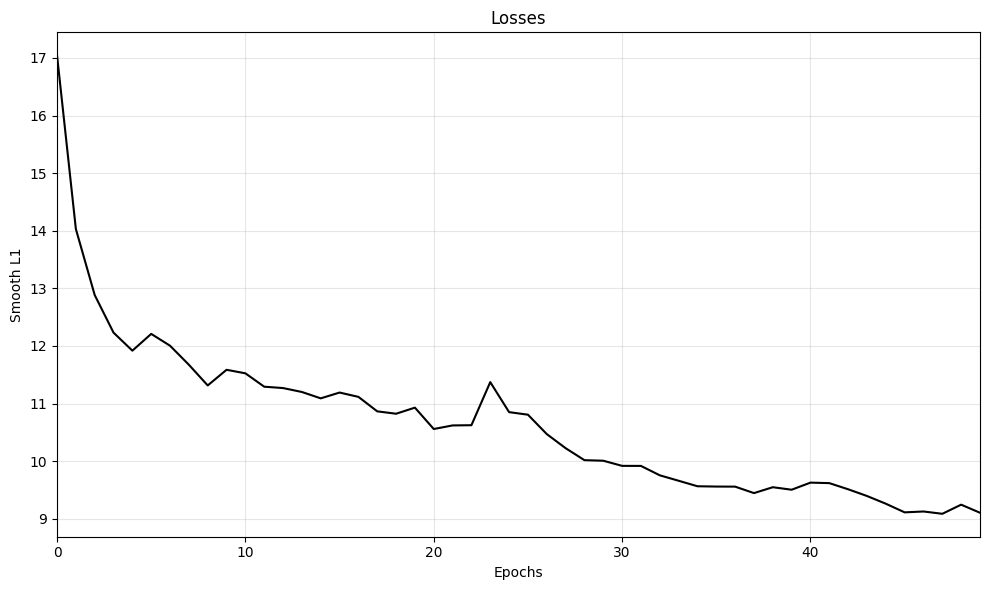

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.title('Losses')
plt.ylabel('Smooth L1')
plt.plot(losses,'k')
plt.xlabel('Epochs')
plt.xlim(0,len(losses)-1)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('torchfem_dataset/losses.png',dpi=300)

In [ ]:
## DiffPool

import torch
import torch.nn as nn
from typing import Dict, Tuple


def build_dense_adj(senders: torch.Tensor, receivers: torch.Tensor, num_nodes: int) -> torch.Tensor:
    """
    Builds a symmetric adjacency matrix for a single graph.
    """
    adj = torch.zeros(num_nodes, num_nodes, device=senders.device)
    adj[senders, receivers] = 1.0
    adj[receivers, senders] = 1.0
    adj.fill_diagonal_(1.0)
    return adj


class GraphConv(nn.Module):
    """
    Lightweight message-passing block used both for embeddings and assignments.
    """

    def __init__(self, node_dim: int, edge_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(node_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(
        self,
        nodes: torch.Tensor,
        edge_attr: torch.Tensor,
        senders: torch.Tensor,
        receivers: torch.Tensor,
    ) -> torch.Tensor:
        msg_input = torch.cat([nodes[senders], edge_attr], dim=-1)
        messages = self.edge_mlp(msg_input)

        agg = torch.zeros(nodes.size(0), messages.size(-1), device=nodes.device)
        agg.index_add_(0, receivers, messages)

        node_input = torch.cat([nodes, agg], dim=-1)
        return self.node_mlp(node_input)


class DiffPoolLayer(nn.Module):
    """
    Single DiffPool layer: learns cluster assignments and pooled embeddings.
    """

    def __init__(
        self,
        input_dim: int,
        edge_dim: int,
        hidden_dim: int,
        assign_dim: int,
        clusters: int,
    ):
        super().__init__()
        self.embed_gnn = GraphConv(input_dim, edge_dim, hidden_dim, hidden_dim)
        self.assign_gnn = GraphConv(input_dim, edge_dim, hidden_dim, clusters)
        self.assign_proj = nn.Linear(clusters, assign_dim)

    def forward(
        self,
        nodes: torch.Tensor,
        adj: torch.Tensor,
        edge_attr: torch.Tensor,
        senders: torch.Tensor,
        receivers: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, torch.Tensor]]:
        z = self.embed_gnn(nodes, edge_attr, senders, receivers)
        s_logits = self.assign_gnn(nodes, edge_attr, senders, receivers)
        s = torch.softmax(s_logits, dim=-1)

        x_pooled = torch.matmul(s.transpose(0, 1), z)
        adj_pooled = torch.matmul(torch.matmul(s.transpose(0, 1), adj), s)

        info = {
            "assign_logits": s_logits,
            "assign_soft": s,
            "node_embed": z,
        }
        return x_pooled, adj_pooled, info


class GraphTemporalDiffPool(nn.Module):
    """
    Temporal forecaster with DiffPool for graph-level compression.
    """

    def __init__(
        self,
        node_dim: int,
        edge_dim: int,
        hidden_dim: int,
        out_dim: int,
        clusters: int,
    ):
        super().__init__()
        self.pre_gnn = GraphConv(node_dim, edge_dim, hidden_dim, hidden_dim)
        self.pool = DiffPoolLayer(hidden_dim, edge_dim, hidden_dim, hidden_dim, clusters)
        self.rnn = nn.LSTM(
            input_size=hidden_dim * clusters,
            hidden_size=hidden_dim,
            batch_first=True,
        )
        self.decoder = nn.Linear(hidden_dim, out_dim)

    def forward(
        self,
        x_t: torch.Tensor,
        edge_attr: torch.Tensor,
        senders: torch.Tensor,
        receivers: torch.Tensor,
        state: Tuple[torch.Tensor, torch.Tensor] | None = None,
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]]:
        pooled_repr = []
        pool_info: Dict[str, torch.Tensor] = {}

        for b in range(x_t.size(0)):
            nodes = self.pre_gnn(x_t[b], edge_attr[b], senders[b], receivers[b])

            adj = build_dense_adj(senders[b], receivers[b], nodes.size(0))
            x_pool, _, info = self.pool(
                nodes,
                adj,
                edge_attr[b],
                senders[b],
                receivers[b],
            )

            pooled_repr.append(x_pool.reshape(-1))
            if b == 0:
                pool_info = {k: v.detach() for k, v in info.items()}

        rnn_in = torch.stack(pooled_repr, dim=0).unsqueeze(1)

        if state is None:
            rnn_out, state = self.rnn(rnn_in)
        else:
            rnn_out, state = self.rnn(rnn_in, state)

        preds = self.decoder(rnn_out.squeeze(1))
        return preds, state, pool_info

    def rollout(
        self,
        node_init: torch.Tensor,
        edge_attr: torch.Tensor,
        senders: torch.Tensor,
        receivers: torch.Tensor,
        steps: int,
    ) -> torch.Tensor:
        preds = []
        x_t = node_init
        state = None

        for _ in range(steps):
            x_t, state, _ = self.forward(x_t, edge_attr, senders, receivers, state)
            preds.append(x_t)

        return torch.stack(preds, dim=1)


if __name__ == "__main__":
    torch.manual_seed(0)

    batch_size, num_nodes, node_dim = 1, 6, 4
    edge_dim, clusters = 3, 3
    out_dim, rollout_steps = node_dim, 5

    node_features = torch.randn(batch_size, num_nodes, node_dim)

    edge_list = []
    for i in range(num_nodes):
        j = (i + 1) % num_nodes
        edge_list.append((i, j))
        edge_list.append((j, i))

    senders = torch.tensor([s for s, _ in edge_list]).unsqueeze(0)
    receivers = torch.tensor([r for _, r in edge_list]).unsqueeze(0)
    edge_features = torch.randn(batch_size, len(edge_list), edge_dim)

    model = GraphTemporalDiffPool(
        node_dim=node_dim,
        edge_dim=edge_dim,
        hidden_dim=32,
        out_dim=out_dim,
        clusters=clusters,
    )

    out, _, info = model(node_features, edge_features, senders, receivers)
    print("Single step output:", out.shape)
    print("Assignment matrix example:", info["assign_soft"].shape)

    preds = model.rollout(
        node_features,
        edge_features,
        senders,
        receivers,
        steps=rollout_steps,
    )
    print("Rollout output:", preds.shape)

    # Expand: swap synthetic data with the real FEM dataset loader, add batching >1,
    #         and plug the pooled embeddings into your training loop with losses/metrics.
